In [24]:
import polars as pl
from nltk.corpus import stopwords
import nltk
import re
import demoji

In [25]:
# Load Stopwords and the dataset
nltk.download('stopwords')
ensw = stopwords.words('english')

df = pl.read_csv("Complete_Data.csv")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\helpkreios\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

For the first step, we wanted to re-format the `ID` section of the data set to remove the leading zeroes.

In [26]:
# Clean ID Part
df = df.select([
    pl.col("ID").apply(lambda id: id.split("-")[1]).cast(pl.Int32),
    pl.exclude("ID")
])



Next up, we will be making sure that our dataset only contains rows that have data on both the `Tweet`  and  `Tweet Url` column

In [27]:
# Remove rows without tweet AND tweet URL
df = df.filter(pl.col("Tweet").is_not_null() & pl.col("Tweet URL").is_not_null())


Since, the following columns: `Location`, `Account bio`, `Group`, `Collector`, `Category`, `Screenshot`, `Rating`, `Reasoning`, `Remarks`, `Reviewer`, `Views`, and `Review` are not needed, we will be removing them.



In [28]:
df = df.drop(['Location', 'Account bio', 'Group','Collector', 'Category','Keywords','Rating','Reasoning', 'Remarks','Reviewer','Review', 'Screenshot', 'Views'])  # Drop multiple columns


We will now be checking how big our dataset is. We do this by checking `df.shape` This revealed that we have 153 unique rows to work with. However, we have some entries that have a null value. To handle this we need to check whether we can replace the null value with a value otherwise we need to fill that up. In the `Content type` column which is categoric column, we cannot simply do this. Hence, I will be reviewing the dataset and input the values manually and importing it again. On the other hand, engagement metrics that are null we can safely set to `0`. 

In [29]:
df = df.fill_null(0)


Let's now explore some relations between the data using scatterplots! We will plot `Followers` against `Followers` to see what kind of accounts usually tweet disinformation. Here we can see there is a huge cluster of accounts that have relatively high following vs their amount of followers.

In [30]:
df1=df.select(
    pl.col("ID"),
    pl.col("Account handle"),
    pl.col("Following"),
    pl.col("Followers"),
    pl.col("Account type").str.strip(),
)

colors = {
    'Identified': 'blue',
    'Media': 'orange',
    'Anonymous': 'red'
}

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

for account_type, color in colors.items():
    filtered_df = df.filter(pl.col('Account type') == account_type)
    fig.add_trace(go.Scatter(
        x=filtered_df['Following'],
        y=filtered_df['Followers'],
        mode='markers',
        text=filtered_df['Account handle'],
        hovertemplate='<b>%{text}</b><br>Following: %{x}<br>Followers: %{y}',
        marker=dict(
            size=10,
            color=color,
            opacity=0.7,
            line=dict(width=0.5, color='black')
        ),
        name=account_type  # Specify the name for each trace
    ))

# Customize the layout
fig.update_layout(
    title='Following vs Followers',
    xaxis_title='Following',
    yaxis_title='Followers',
    hoverlabel=dict(bgcolor='white', font_size=12),
    plot_bgcolor='white',
    legend_title='Account Type'
)




In [31]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

df2 = df.select(
    pl.col("Followers"),
    pl.col("Likes"),
    pl.col("Replies"),
    pl.col("Retweets"),
    pl.col("Quote Tweets")
)






Let's now explore some correlations between the numerical data using heatmap! Here darker color shows a stronger negative correlation while bright colors shows a stronger positive correlation.

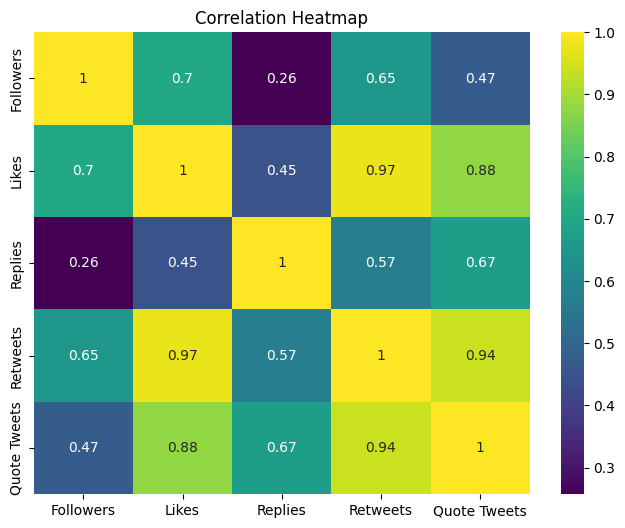

In [32]:
# Compute the correlation matrix
corr_matrix = df2.to_pandas().corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap")
sns.heatmap(corr_matrix, annot=True, cmap="viridis")
plt.show()

Let's now explore how the different numerical data are distributed across groups using bar plots. We only have 3 groups however the media group data only contains 2 data points.

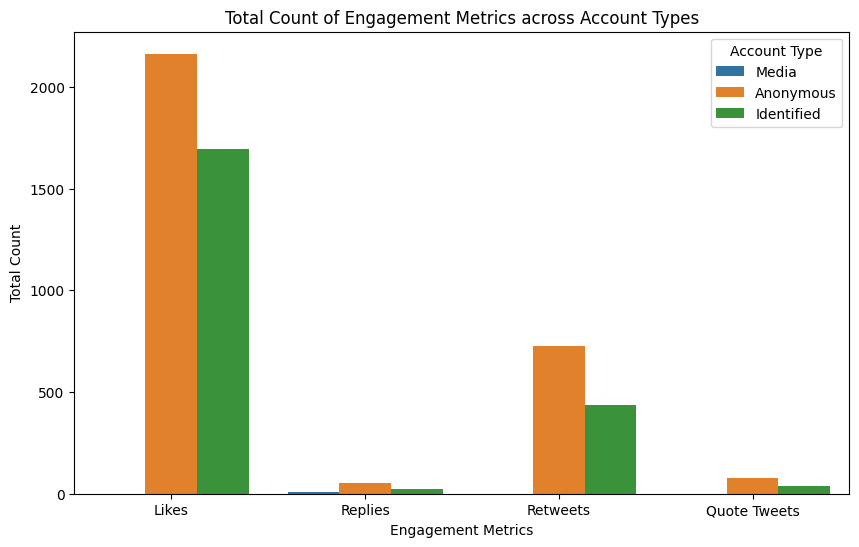

In [33]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns
df3 = df.select(
    pl.col("Account type").str.strip(),
    pl.col("Likes"),
    pl.col("Replies"),
    pl.col("Retweets"),
    pl.col("Quote Tweets")
)

# Compute the total count of engagement metrics
df_total = df3.groupby("Account type").sum()
df_total

# Reshape the data to create a long-form representation
data_melted = df_total.to_pandas().melt(
    id_vars=["Account type"],
    value_vars=["Likes", "Replies", "Retweets", "Quote Tweets"],
    var_name="Engagement",
    value_name="Total Count"
)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_melted,
    x="Engagement",
    y="Total Count",
    hue="Account type"
)
plt.title("Total Count of Engagement Metrics across Account Types")
plt.xlabel("Engagement Metrics")
plt.ylabel("Total Count")
plt.legend(title="Account Type")
plt.show()

In [34]:
# Include only necessary columns
df4 = df.select(
    pl.col("ID"),
    pl.col("Tweet"),
    pl.col("Tweet Translated").alias("Translated")
)

In [35]:
# Change tweet case to lowercase
df4 = df4.select(
    pl.all(),
    pl.col("Translated").apply(lambda tweet: tweet.lower()).alias("Clean")
)

In [36]:
df

ID,Timestamp,Tweet URL,Topic,Account handle,Account name,Account type,Joined,Following,Followers,Tweet,Tweet Translated,Tweet Type,Date posted,Content type,Likes,Replies,Retweets,Quote Tweets
i32,str,str,str,str,str,str,str,i64,i64,str,str,str,str,str,i64,i64,i64,i64
1,"""30/12/99 05:12…","""https://twitte…","""Ninoy being li…","""@arthur_vee""","""The King""","""Anonymous""","""02/12""",2767,4255,"""Cory Aquino: …","""Cory Aquino: …","""Text""","""06/07/22 04:43…","""Rational""",259,0,94,6
2,"""14/03/23 05:19…","""https://twitte…","""Ninoy being li…","""@ItsJamMagno""","""Jam Magno""","""Identified""","""08/15""",0,76100,"""Ninoy Aquino i…","""Ninoy Aquino i…","""Text""","""21/08/22 15:35…","""Rational""",1231,0,271,21
3,"""14/03/23 05:24…","""https://twitte…","""Ninoy being li…","""@Brad_Kardinal…","""PBBM-VPSARA Fo…","""Anonymous""","""09/21""",1787,2067,"""Ninoy is a tra…","""Ninoy is a tra…","""Text, Image""","""21/08/22 03:28…","""Rational""",188,0,78,15
4,"""14/03/23 05:31…","""https://twitte…","""Ninoy being li…","""@WinwinEklabu""","""Mr.Winwin_Situ…","""Anonymous""","""12/15""",6462,7082,"""Ninoy Aquino d…","""Ninoy Aquino d…","""Text, Image""","""22/08/22 06:22…","""Rational""",29,0,10,0
5,"""14/03/23 05:34…","""https://twitte…","""Ninoy being li…","""@cierloX6""","""Cierlo""","""Anonymous""","""02/22""",542,532,"""ninoy aquino i…","""ninoy aquino i…","""Text""","""27/11/22 15:53…","""Rational""",55,0,17,1
6,null,"""https://twitte…","""Ninoy being li…","""@LelangmoVlogg…","""Winnie Corpuz""","""Identified""","""11/21""",430,257,"""Yan Si NiNoy s…","""That's Ninoy h…","""Text, Image, R…","""30/12/21 14:14…","""Emotional""",0,0,0,0
7,"""30/12/99 21:26…","""https://twitte…","""Ninoy being li…","""@iskonglasalis…","""Benedict Excon…","""Identified""","""04/09""",2568,6097,"""Irony: The Com…","""Irony: The Com…","""Text, Reply""","""02/01/2020 02:…","""Rational""",5,0,0,0
8,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@mendozadino""","""Ryan Padua""","""Identified""","""07/10""",260,37,"""@senbongrevill…","""@senbagrevilla…","""Text""","""1/17/2020""","""Emotional""",0,0,0,0
9,"""30/12/99 21:31…","""https://twitte…","""Ninoy being li…","""@dTnalakRiderS…","""KulasSR""","""Anonymous""","""10/16""",1519,3275,"""Meron akong hi…","""I have a suspi…","""Reply""","""Jan 23, 2020""","""Emotional""",6,0,1,0


In [37]:
# Remove hashtags
df4 = df4.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(lambda tweet: re.sub("#(\w+)", '', tweet))
)

In [38]:
# Replace all emojis into interpretation
def emoji_to_word(tweet):
  for symbol, interpretation in demoji.findall(tweet).items():
    interpretation = interpretation.lower()
    # Turn flag: Philippines into flagphilippines 
    interpretation = re.sub('[^0-9a-z]+', '', interpretation)
    # replace all emojis to "emojiinterpretation "
    tweet = re.sub(symbol, interpretation+' ', tweet)
  return tweet

df4 = df4.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(emoji_to_word)
)

In [39]:
# Remove non alphanumeric characters
df4 = df4.select(
    pl.exclude("Clean"),
    pl.col("Clean").apply(lambda tweet: re.sub('[^0-9a-z]+', ' ', tweet))
)

In [40]:
# Cast Tweets to word array instead of long string.
df4 = df4.select(
    pl.all(),
    pl.col("Clean").apply(lambda tweet: tweet.split()).cast(pl.List(str)).alias("Tokenized")
)

In [41]:
# Strip english stopwords
df4 = df4.select(
    pl.all(),
    pl.col("Tokenized").arr.eval(pl.element().filter(~pl.element().is_in(ensw)), parallel=True).alias("Stopwords Removed")
)

In [42]:
# Stem and Lemmatize.
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
# Initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df4 = df4.select(
    pl.all(),
    pl.col("Stopwords Removed").apply(lambda words: [stemmer.stem(word) for word in words.to_list()]).alias("Stemmed"),
    pl.col("Stopwords Removed").apply(lambda words: [lemmatizer.lemmatize(word) for word in words.to_list()]).alias("Lemmatized")
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helpkreios\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
def serialize(arr):
  return " ".join(arr)
df_serialized = df4.select(
    pl.col("ID"),
    pl.col("Tweet"),
    pl.col("Translated"),
    pl.col("Clean"),
    pl.col("Tokenized").apply(serialize).cast(str),
    pl.col("Stopwords Removed").apply(serialize).cast(str),
    pl.col("Stemmed").apply(serialize).cast(str),
    pl.col("Lemmatized").apply(serialize).cast(str)
)
df_serialized.write_csv("clean.csv")

In [44]:
# from collections import Counter
# import matplotlib.pyplot as plt


# word_list = df_serialized['Lemmatized'].to_list()
# word_string = ' '.join(word_list)


In [45]:
# word_string

'cory aquino duly elected president gossip dictator revolutionary president power grab fact ninoy hero gossip organised cpp npa ndf traitor highest order fact ninoy aquino traitor joined force npa incite rebellion country joined force malaysia supporting mnlf terrorist group back destabilizing mindanao stop claim sabah killed family ninoy traitor idiot destabilizer ninoy sold sabah malaysia ninoy communist like joma sison ninoy father noynoy former nganga president ninoy husband cory stole presidency pfem benigno ninoy aquino betrayed philippine root cause martial law never hero sold sabah malaysia suspected mastermind plaza miranda quiapo bombing august 21 1969 killing 9 wounding 95 etc ninoy aquino day abolished insult many filipino remember seen many video threatening bomb philippine reason terrorist npa formed call heroism b alisin na ninoy aquino day august 21 1983 traitor fakehero gc4sm inc ninoy aquino convicted criminal well known supporter hukbalahap kumander dante tarlac reas